**Start by running the following preamble code block:**

In [ ]:
library(dplyr, warn.conflicts = FALSE)
library(Matrix)
library(ggplot2)
library(lubridate, warn.conflicts = FALSE)
if(!require('gridExtra', warn.conflicts = FALSE)) {
    install.packages('gridExtra')
    library(gridExtra)
}
if(!require('numDeriv', warn.conflicts = FALSE)) {
    install.packages('numDeriv')
    library(numDeriv)
}

theme_set(theme_bw())

data_dir <-  '~/shared/ssim-ghg-data/inversion_examples'

n_land_regions <- 11
n_ocean_regions <- 11
n_months <- 24

source('utilities.R')
source('setup-obs-and-jacobian.R')
load(file.path(data_dir, 'misc', 'truth_array.rda'))
truth_array <- truth_array[, -1, , 1]
inversion_number <- 44
x_true <- pmax(pmin(as.vector(-truth_array[, , inversion_number]), 5), -5)

Loading required package: numDeriv

Warning message in library(package, lib.loc = lib.loc, character.only = TRUE, logical.return = TRUE, :
“there is no package called ‘numDeriv’”
Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



# A hierarchical model extension of the toy problem

In this notebook, we extend the model underlying the batch inverson to have a hierarchical component, and estimate its parameters using Markov chain Monte Carlo (MCMC).

## The base batch model

The base batch model is
\begin{align*}
    (\mathbf{z} \mid \mathbf{x})
    & \sim \mathcal{N}(\mathbf{H} \mathbf{x}, \mathbf{S}_z), \\
    \mathbf{x}
    & \sim \mathcal{N}(\mathbf{x}_0, \mathbf{S}_0), \\
\end{align*}
where $\mathbf{z} = (z_1, \ldots, z_{n_z})^T$ contains the $n_z$ observations, $\mathbf{H}$ is the $n_z \times n_x$ Jacobian matrix, $\mathbf{x} = (x_1, \ldots, x_{n_x})^T$ contains the $n_x$ entries of the state vector, $\mathbf{x}_0$ is the state vector prior mean, and $\mathbf{S}_0$ is the state vector prior covariance matrix.

For simplicity, we have that $\mathbf{x}_0 = (0, \ldots, 0)^T$, and that $\mathbf{S}_z$ is a diagonal matrix. 

The inversion occurs over 24 months and the state vector $\mathbf{x}$ has entries for each of the 22 TransCom regions and for each of the 24 months from 2014-09 to 2016-08 (therefore, it has 528 entries). The entries are organized region-by-region and month-by-month in $\mathbf{x}$:
$$
    \mathbf{x} = (\text{region 1 in month 2014-09}, \text{region 1 in month 2014-10}, \ldots, \text{region 1 in month 2016-08}, \ldots, \text{region 22 in month 2016-08})^T
$$

Let's unpack each of the pieces below.

## Flux prior

We set $\mathbf{S}_0$ so that the entries within each region are correlated in time, but there is no correlation between regions. The first 11 regions correspond to land regions, and the last 11 regions to ocean regions; we allow for land and ocean to have different variance and correlation. Overall, then, $\mathbf{S}_0$ has the structure
$$
    \mathbf{S}_0 = \begin{pmatrix}
        \mathbf{S}_0^\text{land}
        & \\
        & \ddots \\
        & & \mathbf{S}_0^\text{land} \\
        & & & \mathbf{S}_0^\text{ocean} \\
        & & & & \ddots \\
        & & & & & \mathbf{S}_0^\text{ocean}
    \end{pmatrix}
$$
where
$$
  \mathbf{S}_0^\text{land} = \tau_\text{land}^2 \begin{pmatrix}
    1 & \rho_\text{land} & \rho_\text{land}^2 & \cdots & \rho_\text{land}^{23} \\
    \rho_\text{land} & 1 & \rho_\text{land} & \cdots & \rho_\text{land}^{22} \\
    \rho_\text{land}^2 & \rho_\text{land} & 1 & \cdots & \rho_\text{land}^{21} \\
    \vdots & \vdots & \vdots & \ddots & \vdots \\
    \rho_\text{land}^{23} & \rho_\text{land}^{22} & \rho_\text{land}^{21} & \cdots & 1
  \end{pmatrix}.
$$
Here, $\tau_\text{land} > 0$ is the land standard deviation; $-1 < \rho_\text{land} < 1$ is the land autocorrelation; and $\mathbf{S}_0^\text{ocean}$ is defined identically except with parameters $\tau_\text{ocean}$ and $\rho_\text{ocean}$.

**The following function produces this covariance matrix:**

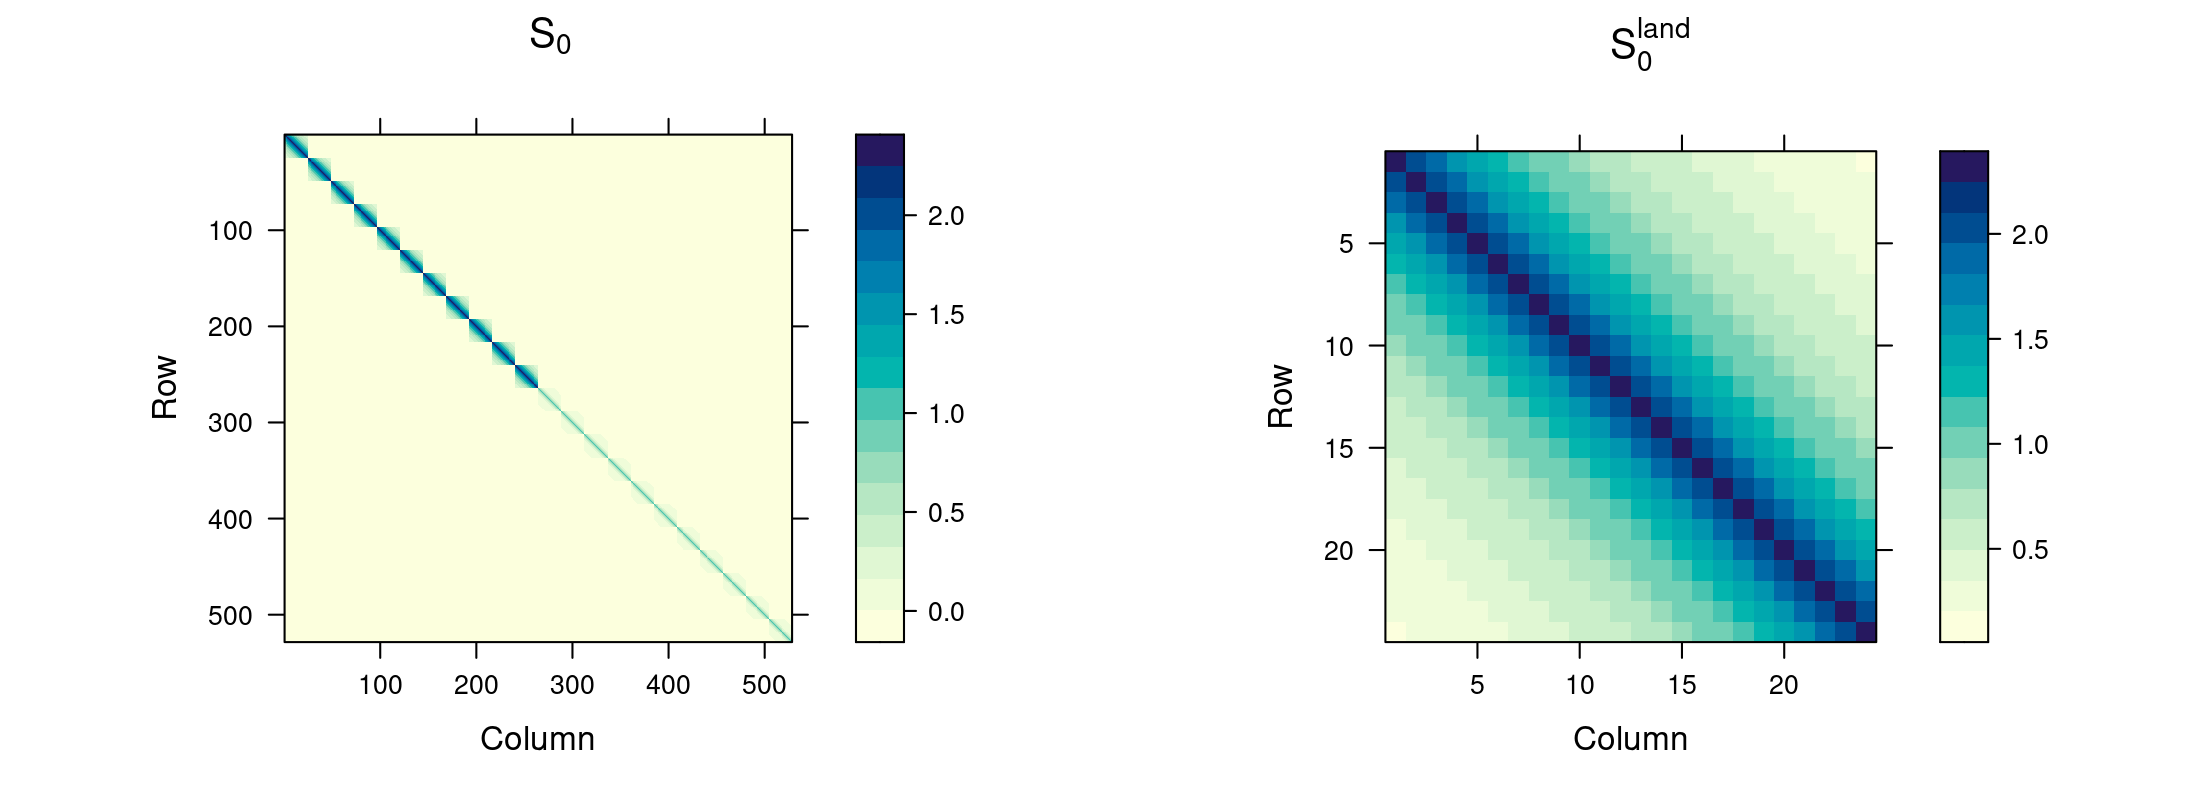

In [2]:
# Construct the covariance matrix of an AR(1) process
ar1_covariance <- function(n, rho, stdev = 1) {
  (stdev ^ 2) * toeplitz(rho ^ (0 : (n - 1)))
}

# Construct the prior covariance matrix. The vector parameter theta contains
# - theta[1]: observation error standard deviation (sigma)
# - theta[2]: land standard deviation (tau_land^2)
# - theta[3]: land correlation (rho_land)
# - theta[4]: ocean standard deviation (tau_ocean^2)
# - theta[5]: ocean correlation (rho_ocean)
get_S0 <- function(theta) {
  S0_land <- ar1_covariance(n_months, theta[3], theta[2])
  S0_ocean <- ar1_covariance(n_months, theta[5], theta[4])
  n_dim <- n_months * (n_land_regions + n_ocean_regions)
  output <- matrix(0, nrow = n_dim, ncol = n_dim)
  for (i in seq_len(n_land_regions + n_ocean_regions)) {
    start <- (i - 1) * n_months + 1
    end <- i * n_months
    if (i <= n_land_regions) {
      output[start:end, start:end] <- S0_land
    } else {
      output[start:end, start:end] <- S0_ocean
    }
  }
  output
}

S0_example <- get_S0(c(3, 1.5, 0.9, 1, 0.7))
options(repr.plot.width = 11, repr.plot.height = 4, repr.plot.res = 200)
gridExtra::grid.arrange(
    lattice::levelplot(S0_example, xlab = 'Column', ylab = 'Row', ylim=c(528.5, 0.5), main = expression(S[0])),
    lattice::levelplot(S0_example[1 : 24, 1 : 24], xlab = 'Column', ylab = 'Row', ylim=c(24.5, 0.5), main = expression(S[0]^'land')),
    nrow = 1
)

## Observation error covariance

For the observation error covariance, we assume that
$$
\mathbf{S}_z = \sigma^2 \begin{pmatrix}
  1 \\
  & \ddots \\
  & & 1
\end{pmatrix}.
$$

This means that all observations get the same error standard deviation $\sigma^2$.

## Parameter prior

Our unknown parameters are therefore ${\boldsymbol \theta} = (\sigma, \tau_\mathrm{land}, \rho_\mathrm{land}, \tau_\mathrm{ocean}, \rho_\mathrm{land})^T$. We need to set a prior on these components. We choose the following:
\begin{gather}
  \sigma \sim \mathrm{Half}\text{-}\mathcal{N}(3^2),
  \quad \tau_\mathrm{land} \sim \mathrm{Half}\text{-}\mathcal{N}(3^2),
  \quad \tau_\mathrm{ocean} \sim \mathrm{Half}\text{-}\mathcal{N}(3^2) \\
  \rho_\mathrm{land} \sim \mathrm{Unif}(-1, 1),
  \quad \rho_\mathrm{ocean} \sim \mathrm{Unif}(-1, 1).
\end{gather}
**These are visualized below:**

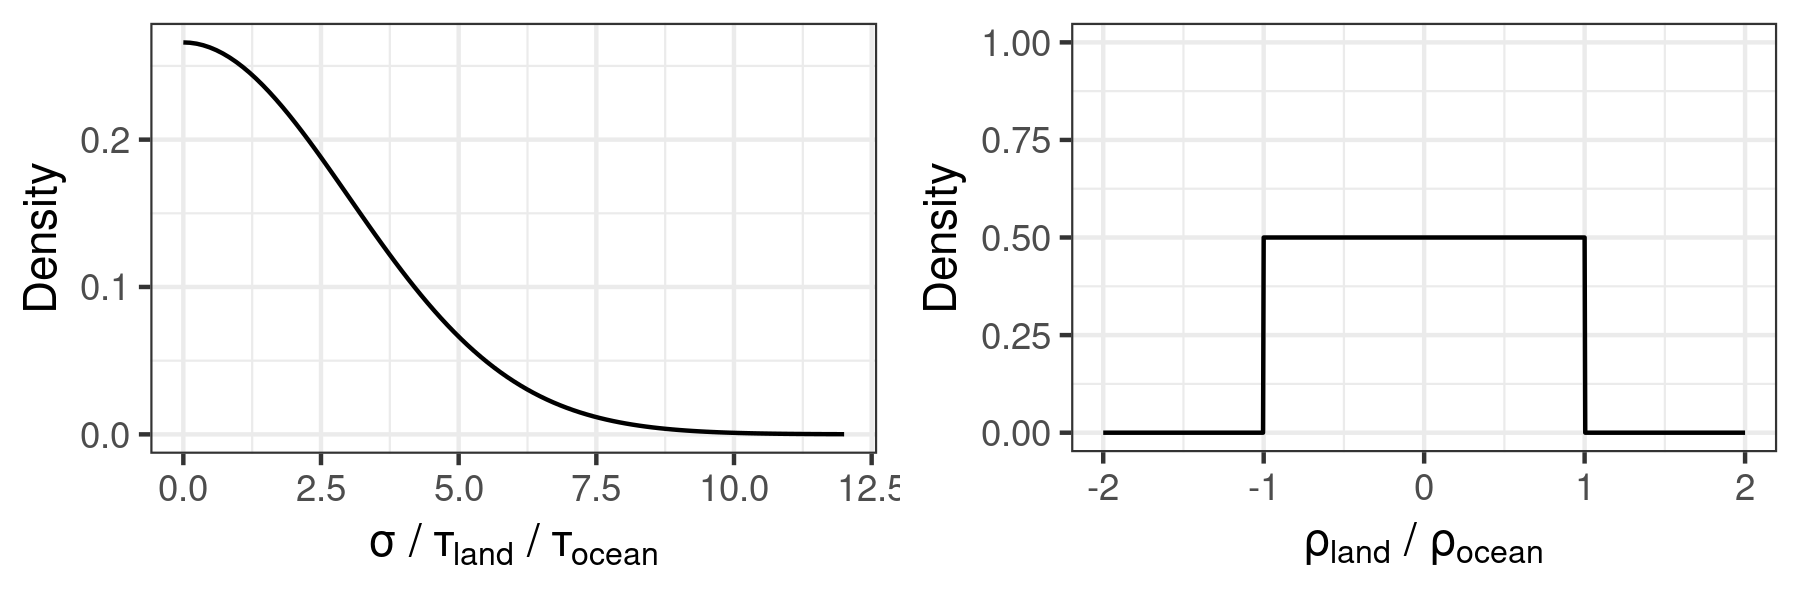

In [3]:
options(repr.plot.width = 6, repr.plot.height = 2, repr.plot.res = 300)
gridExtra::grid.arrange(
  ggplot() +
    geom_function(
      fun = function(x) 2 * dnorm(x, sd = 3),
      xlim = c(0, 12)
    ) +
    labs(x = expression(sigma*' / '*tau['land']*' / '*tau['ocean']), y = 'Density'),
  ggplot() +
    geom_function(
      fun = function(x) ifelse(x < -1 | x > 1, 0, 0.5),
      xlim = c(-2, 2),
      n = 1001
    ) +
    ylim(0, 1) +
    labs(x = expression(rho['land']*' / '*rho['ocean']), y = 'Density'),
  nrow = 1
)

You can see that for the standard deviations (left plot), the prior distribution admits be anything between 0 and 10. For the correlation, the value can be anything between -1 and 1.

To investigate what this prior says about the fluxes, we can perform a Monte Carlo experiment (this is not Markov chain Monte Carlo! We do that later):
1. Simulate $\boldsymbol \theta$ from its prior
2. Simulate $\mathbf{x}$ from $p(\mathbf{x} \mid \boldsymbol \theta)$

The following code does this:

In [4]:
sigma_prior_sd <- 3
tau_land_prior_sd <- 3
tau_ocean_prior_sd <- 3
theta_names <- c('sigma', 'tau_land', 'rho_land', 'tau_ocean', 'rho_ocean')

n_samples <- 2000L
theta_samples_prior <- matrix(NA, nrow = n_samples, ncol = 5)
colnames(theta_samples_prior) <- theta_names
x_samples_prior <- matrix(NA, nrow = n_samples, ncol = ncol(H))
for (iteration in seq_len(n_samples)) {
  theta <- c(
    abs(rnorm(1, sd = sigma_prior_sd)),
    abs(rnorm(1, sd = tau_land_prior_sd)),
    runif(1, -1, 1),
    abs(rnorm(1, sd = tau_ocean_prior_sd)),
    runif(1, -1, 1) 
  )
  S0 <- get_S0(theta)
  x <- rmvnorm(rep(0, ncol(H)), S = S0)
  theta_samples_prior[iteration, ] <- theta    
  x_samples_prior[iteration, ] <- x
}

print(head(theta_samples_prior))

         sigma  tau_land   rho_land tau_ocean   rho_ocean
[1,] 0.3581277 1.8967761  0.5587682 2.7585769 -0.85920955
[2,] 1.4587197 7.9250505  0.5215064 0.3604579  0.54619370
[3,] 1.3285487 2.4430612 -0.6811950 4.4779541 -0.06866245
[4,] 3.7860404 0.5908289 -0.1851189 4.9602984 -0.83410613
[5,] 2.7096061 2.7571900 -0.9568978 1.2976511 -0.03661499
[6,] 1.5521090 1.7040074  0.9433719 0.9206774 -0.73697402


We can look at global total monthly land and ocean fluxes and their prior 95% intervals to see what this prior says:

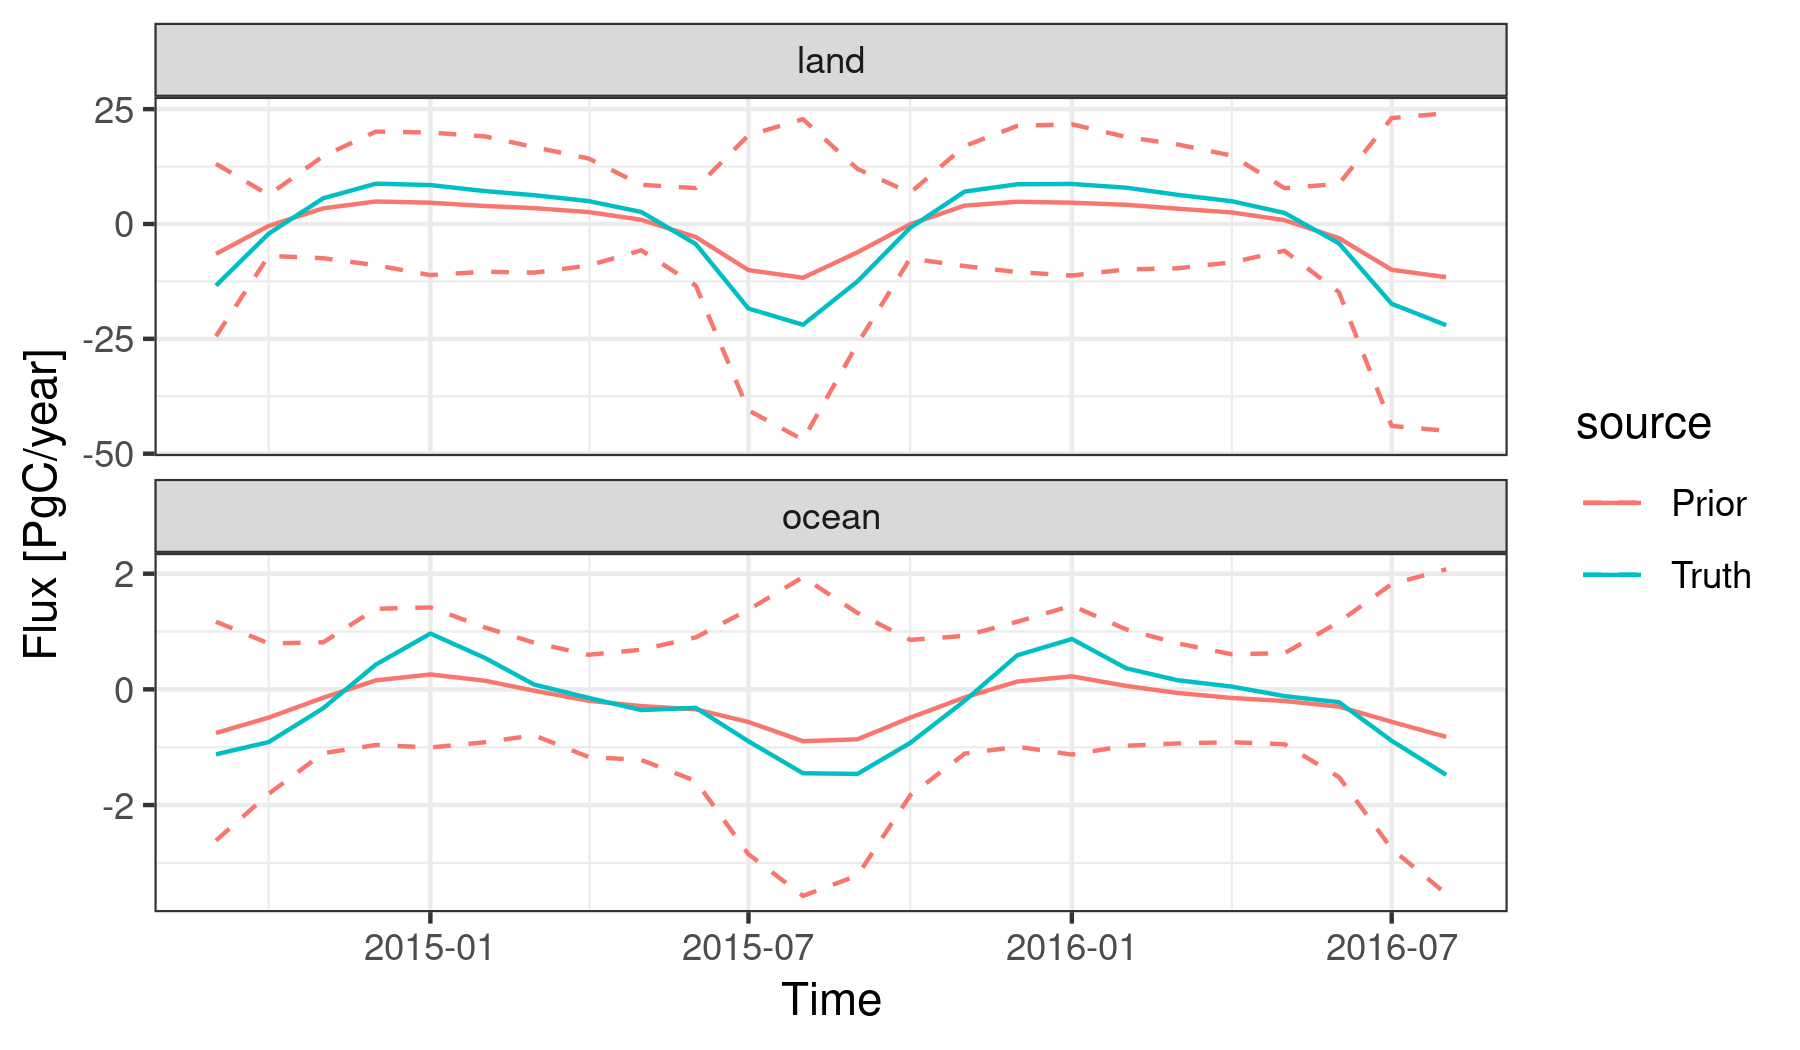

In [5]:
# x_to_land_ocean_flux is defined in utilities.R
land_ocean_flux_true <- x_to_land_ocean_flux(x_true)
land_ocean_flux_prior <- x_to_land_ocean_flux(rep(0, ncol(H)), x_samples_prior)

options(repr.plot.width = 6, repr.plot.height = 3.5, repr.plot.res = 300)
bind_rows(
    land_ocean_flux_true %>%
        mutate(source = 'Truth'),
    land_ocean_flux_prior %>%
        mutate(source = 'Prior')    
) %>%
    ggplot(aes(time, colour = source)) +
        geom_line(mapping = aes(y = flux)) +
        geom_line(mapping = aes(y = flux_q025), linetype = 'dashed', na.rm = TRUE) +
        geom_line(mapping = aes(y = flux_q975), linetype = 'dashed', na.rm = TRUE) +
        facet_wrap(~ region_type, ncol = 1, scales = 'free_y') +
        labs(x = 'Time', y = 'Flux [PgC/year]')

In terms of CO2, this is a pretty uninformative prior, particularly for land.

## The full model, and its posterior

We can now write the full model as:
\begin{gather}
    (\mathbf{z} \mid \mathbf{x}, \sigma)
    \sim \mathcal{N}(\mathbf{H} \mathbf{x}, \mathbf{S}_z), \\
    (\mathbf{x} \mid \tau_\mathrm{land}, \rho_\mathrm{land}, \tau_\mathrm{ocean}, \rho_\mathrm{ocean}),
    \sim \mathcal{N}{(\mathbf{x}_0,\mathbf{S}_0)} \\
    \sigma \sim \mathrm{Half}\text{-}\mathcal{N}(3^2),
          \quad \tau_\mathrm{land} \sim \mathrm{Half}\text{-}\mathcal{N}(3^2),
          \quad \tau_\mathrm{ocean} \sim \mathrm{Half}\text{-}\mathcal{N}(3^2) \\
    \rho_\mathrm{land} \sim \mathrm{Unif}(-1, 1),
          \quad \rho_\mathrm{ocean} \sim \mathrm{Unif}(-1, 1).
\end{gather}

In the slides, we derive the log posterior distribution $\log p({\boldsymbol \theta} \mid \mathbf{z})$ to be:
$$
    \log p({\boldsymbol \theta} \mid \mathbf{z})
    = \log p(\mathbf{z} \mid {\boldsymbol \theta}) + \log p({\boldsymbol \theta}) + C,
$$
where $\log p(\mathbf{z} \mid {\boldsymbol \theta})$ is given by
$$
    \log p(\mathbf{z} \mid {\boldsymbol \theta}) =
    -\frac{1}{2}\log |\mathbf{H}\mathbf{S}_0\mathbf{H}^T+\mathbf{S}_z| -
      \frac{1}{2}
        \tilde{\mathbf{z}}^T
        (\mathbf{H}\mathbf{S}_0\mathbf{H}^T+\mathbf{S}_z)^{-1}
        \tilde{\mathbf{z}}
    + C_2.
$$
where $\tilde{\mathbf{z}} = \mathbf{z} - \mathbf{H}\mathbf{x}_0$ and $C_2$ is another constant. The notes show how this can be computed efficiently using the Woodbury matrix identity; the result is:
\begin{align*}
    \log |\mathbf{S}_z + \mathbf{H} \mathbf{S}_0 \mathbf{H}^T|
    & = \log |\mathbf{O}| + \log |\mathbf{S_z}| + \log |\mathbf{S}_0| \\
    \tilde{\mathbf{z}}^T
    (\mathbf{H}\mathbf{S}_0\mathbf{H}^T+\mathbf{S}_z)^{-1}
    \tilde{\mathbf{z}}
    & = \tilde{\mathbf{z}}^T \mathbf{S}_z^{-1}   \tilde{\mathbf{z}}
        - \tilde{\mathbf{z}}^T \mathbf{S}_z^{-1} \mathbf{H} \mathbf{O}^{-1} \mathbf{H}^T \mathbf{S}_z^{-1}     \tilde{\mathbf{z}}.
\end{align*}

The other part of the posterior, $\log p({\boldsymbol \theta})$, can be computed using standard functions in R.

Code to compute $\log p({\boldsymbol \theta} \mid \mathbf{z})$ up to the unknown constant $C$ appears later in this notebook.

# Simulated data for this experiment

Shortly we will start doing some inversions. For those inversions, we need some data.

Although fluxes are estimated from 2014-09 to 2016-08, we only use data up to 2015-08. We will use this later to see what the posterior distribution is for the fluxes after 2015-08, when there is no data. The number of observations (and their type, OCO-2 or in situ) is shown in the following plot:

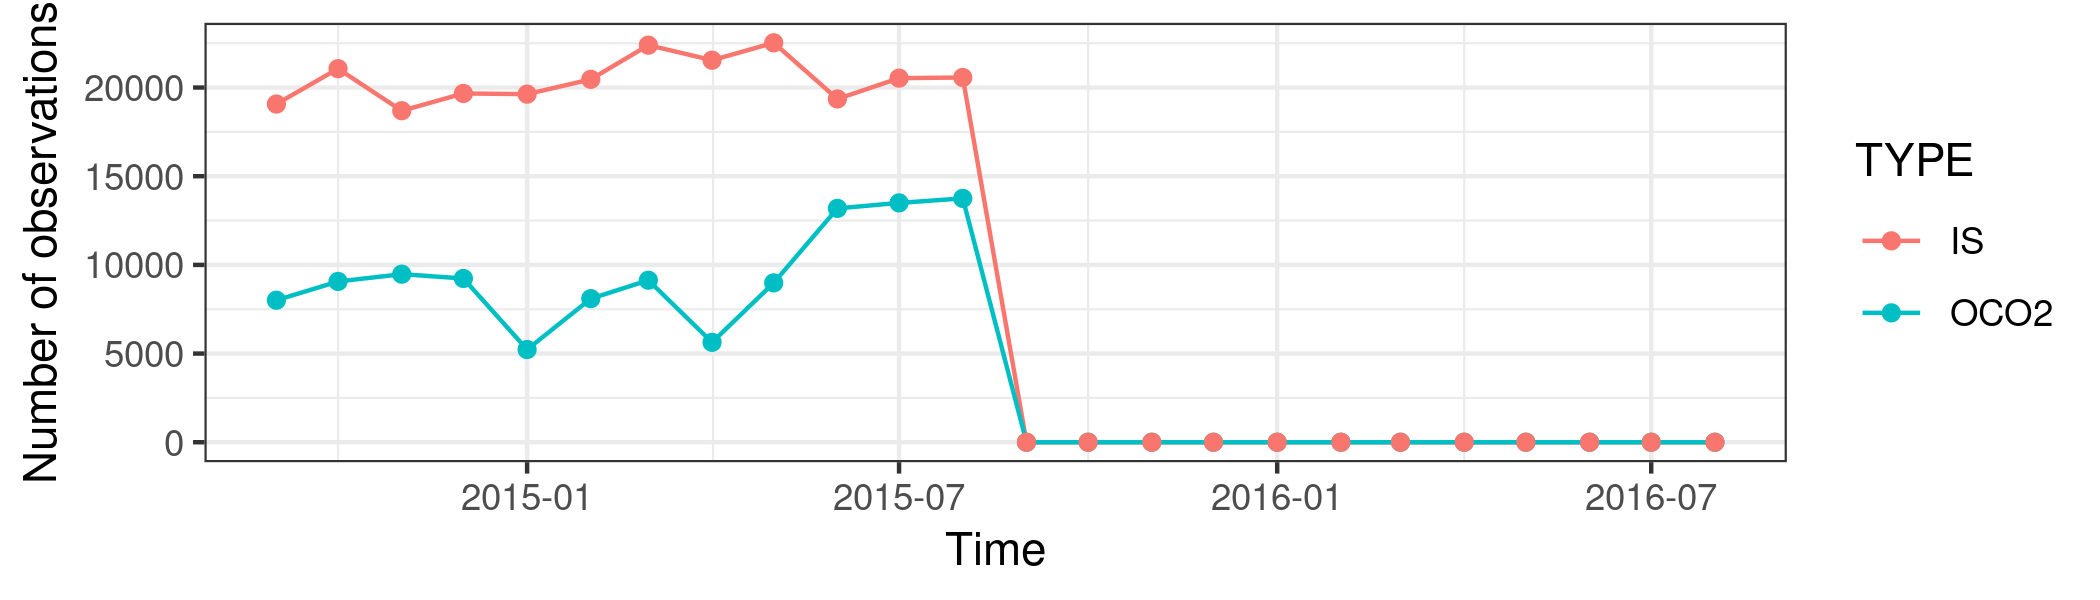

In [6]:
options(repr.plot.width = 7, repr.plot.height = 2, repr.plot.res = 300)
expand.grid(
  time = seq(ymd_hms('2014-09-01 00:00:00'), ymd_hms('2016-08-01 00:00:00'), by = 'month'),
  TYPE = unique(obs_catalog$TYPE),
  stringsAsFactors = FALSE
) %>%
  left_join(
    obs_catalog %>%
      group_by(TYPE, time = floor_date(DATE, 'month')) %>%
      summarise(n = n(), .groups = 'drop'),
    by = c('time', 'TYPE')
  ) %>%
  mutate(n = ifelse(is.na(n), 0, n)) %>%
    ggplot(aes(time, n, colour = TYPE)) +
      geom_line() +
      geom_point() +
      labs(x = 'Time', y = 'Number of observations')

We hypothesize "true" fluxes under a hypothesized "true" error distribution. Assume $\mathbf{x}_\mathrm{true}$ is the true flux; we simulate
$$
  z_\mathrm{sim} = \mathbf{H} \mathbf{x}_\mathrm{true} + {\boldsymbol \epsilon}_\mathrm{sim}
$$
where ${\boldsymbol \epsilon}_\mathrm{sim} = (\epsilon_1^\mathrm{true}, \ldots, \epsilon_{n_z}^\mathrm{true})^T$, and we simulate $\epsilon_i^\mathrm{true}$ from $\mathcal{N}(0, \sigma_\mathrm{true}^2)$.

In the code below, $\mathbf{H}$ was loaded earlier, in the preamble, and we set $\sigma_\mathrm{true} = 3$:

In [7]:
sigma_true <- 3
z_sim <- as.vector(H %*% x_true) + rnorm(nrow(H), sd = sigma_true)

# Estimating the parameters

We start by giving the function to compute $\log p({\boldsymbol \theta} \mid \mathbf{z})$ (it also returns some other useful quantities):

In [8]:
# Precalculate H^T H and H^T z
Ht_H <- crossprod(H)
Ht_z <- crossprod(H, z_sim)

# NOTE: chol_solve is defined in utilities.R
log_posterior <- function(theta) {
  if(
    theta[1] <= 0
    || theta[2] <= 0
    || theta[3] <= -1 || theta[3] >= 1
    || theta[4] <= 0
    || theta[5] <= -1 || theta[5] >= 1
  ) {
    return(list(
      log_density = -Inf
    ))
  }

  S0 <- get_S0(theta)
  chol_S0 <- chol(S0)
  Q0 <- chol2inv(chol_S0)
  O <- Ht_H / theta[1] ^ 2 + Q0
  chol_O <- chol(O)
  x_hat <- as.vector(chol_solve(chol_O, Ht_z / theta[1] ^ 2))

  woodbury_lhs <- crossprod(z_sim) / theta[1] ^ 2
  woodbury_rhs <- crossprod(Ht_z, x_hat) / theta[1] ^ 2
  woodbury_log_det <- (
    2 * sum(log(diag(chol_O)))
    + 2 * sum(log(diag(chol_S0)))
    + 2 * length(z_sim) * log(theta[1])
  )

  log_density <- as.vector(
    - 0.5 * woodbury_log_det
    - 0.5 * woodbury_lhs
    + 0.5 * woodbury_rhs
    + dnorm(theta[1], mean = 0, sd = sigma_prior_sd, log = TRUE)
    + dnorm(theta[2], mean = 0, sd = tau_land_prior_sd, log = TRUE)
    + dnorm(theta[4], mean = 0, sd = tau_ocean_prior_sd, log = TRUE)
  )

  list(
    log_density = log_density,
    x_hat = x_hat,
    chol_O = chol_O
  )
}

For this problem, this function is pretty fast; it's run time depends on $n_x$:

In [9]:
system.time(print(log_posterior(c(3, 1, 0.1, 1, 0.1))$log_density))

[1] -574178.1


   user  system elapsed 
  0.114   0.124   0.041 

## Finding the posterior mode

We can now just use a generic optimization routine to find the posterior mode:

In [10]:
fit <- nlminb(
  c(1, 1, 0, 1, 0),
  function(theta) {
    -log_posterior(theta)$log_density
  },
  control = list(trace = 2)
)

  0:     1616016.3:  1.00000  1.00000  0.00000  1.00000  0.00000
  2:     635867.98:  2.08437  1.44470 0.378477  1.77193 0.237149
  4:     574926.58:  2.89384  2.18469 -0.0220554 0.0687648 -0.544681
  6:     574174.02:  3.01732  1.55725 0.0751568  1.36083 -0.185975
  8:     574157.30:  3.00052  1.37226 0.686900  1.44953 0.303059
 10:     574155.99:  2.99893  1.37469 0.676718  1.45510 0.307127
 12:     574153.07:  2.99923  1.37418 0.659979  1.49963 0.340554
 14:     574147.58:  2.99847  1.36092 0.656610  1.71686 0.265199
 16:     574143.68:  3.00247  1.35669 0.600849  1.75099 0.408679
 18:     574143.30:  3.00242  1.35711 0.596693  1.75188 0.403794
 20:     574134.27:  3.00016  1.26949 0.503210  2.26631 0.284020
 22:     574132.40:  3.00188  1.15618 0.270304  2.37187 0.271949
 24:     574131.52:  3.00130  1.25682 0.343813  2.43399 0.231196
 26:     574131.51:  3.00146  1.24909 0.343269  2.43017 0.233273


In [11]:
theta_mode <- fit$par
names(theta_mode) <- c('sigma', 'tau_land', 'rho_land', 'tau_ocean', 'rho_ocean')
print(theta_mode)

    sigma  tau_land  rho_land tau_ocean rho_ocean 
3.0014612 1.2491249 0.3433845 2.4303146 0.2335367 


We can use this estimate of $\boldsymbol \theta$ to find an estimate of $\mathbf{x}$, which comes from the conditional distribution $p(\mathbf{x} \mid {\boldsymbol \theta} = \hat{\boldsymbol \theta}, \mathbf{z})$:

In [12]:
S0_mode <- get_S0(theta_mode)
Q_hat_mode <- Ht_H / theta_mode[1] ^ 2 + solve_sym(S0_mode)
S_hat_mode <- solve_sym(Q_hat_mode)
chol_S_hat_mode <- chol(S_hat_mode)
x_hat_mode <- as.vector(solve_sym(Q_hat_mode, Ht_z / theta_mode[1] ^ 2))
print(head(x_hat_mode))

[1] 1.0102540 2.6551660 0.7182449 0.8758817 0.9927264 0.8845853


We can draw samples from $p(\mathbf{x} \mid {\boldsymbol \theta} = \hat{\boldsymbol \theta}, \mathbf{z})$, and look at the land/ocean global total fluxes:

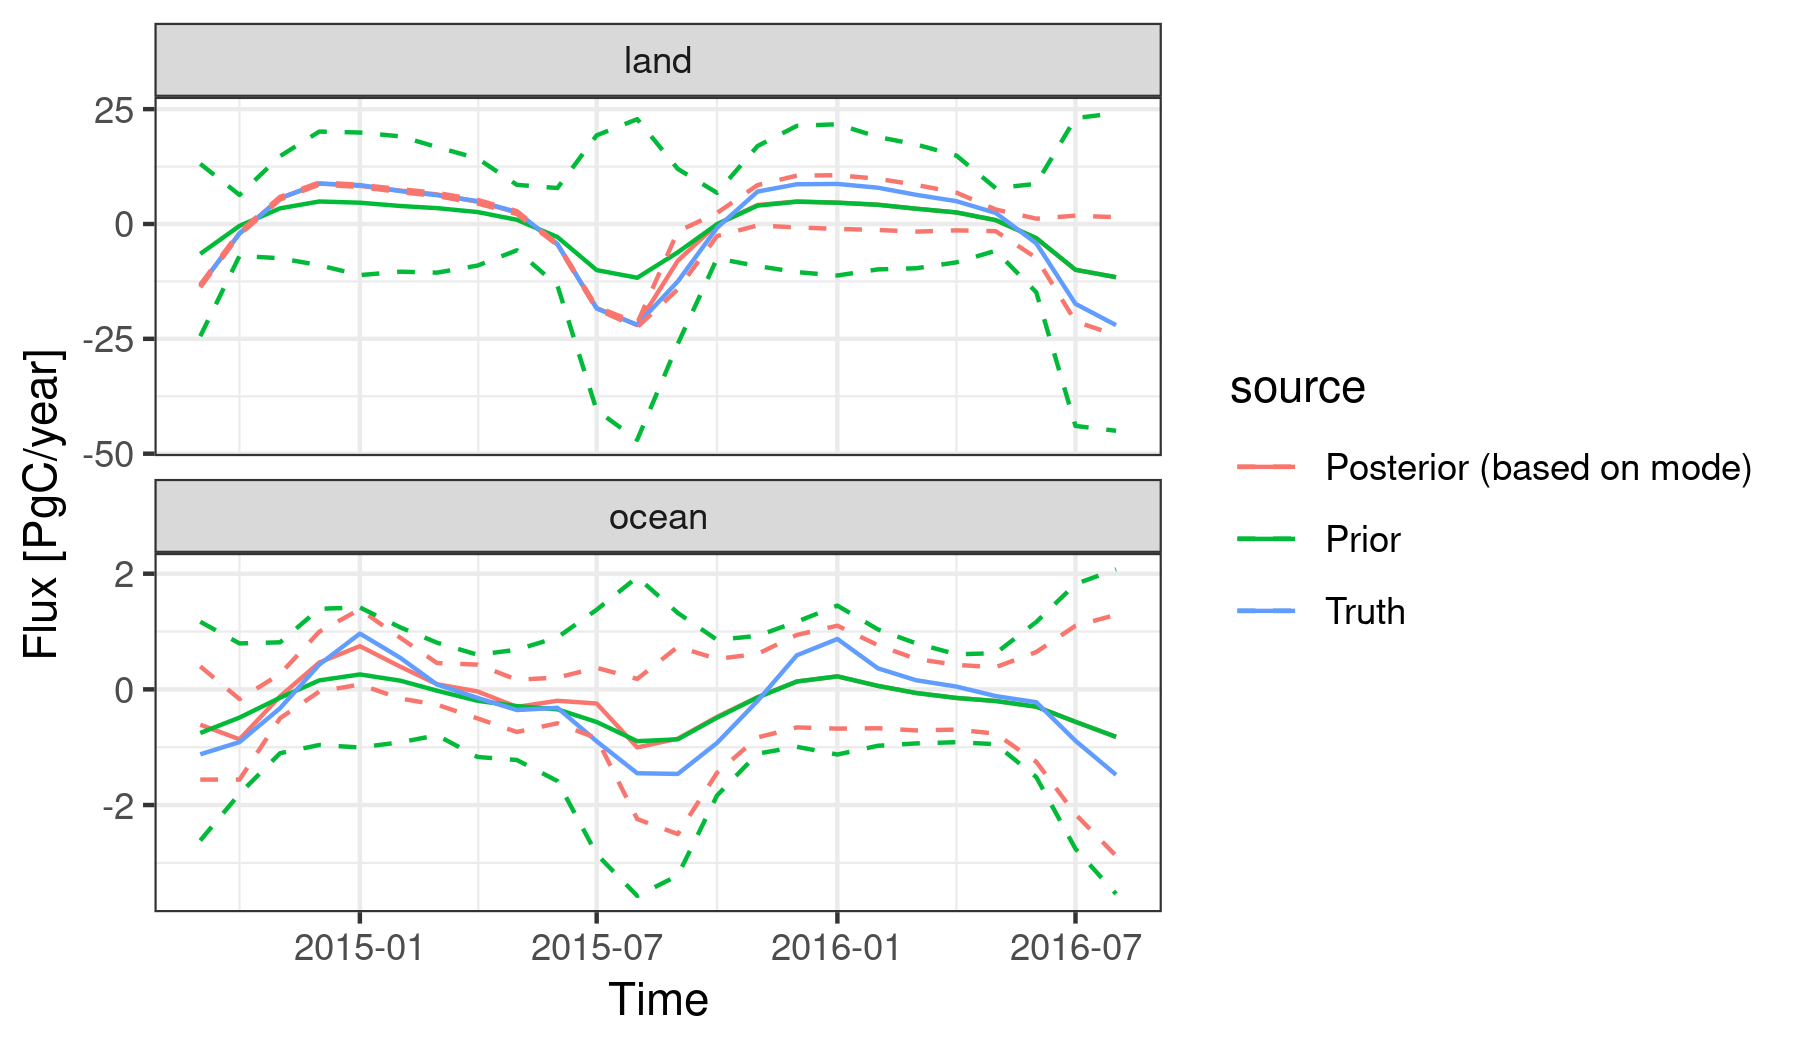

In [13]:
x_samples_mode <- t(replicate(n_samples, rmvnorm(x_hat_mode, chol_S = chol_S_hat_mode)))

land_ocean_flux_mode <- x_to_land_ocean_flux(x_hat_mode, x_samples_mode)

options(repr.plot.width = 6, repr.plot.height = 3.5, repr.plot.res = 300)
bind_rows(
    land_ocean_flux_true %>%
        mutate(source = 'Truth'),
    land_ocean_flux_prior %>%
        mutate(source = 'Prior'),
    land_ocean_flux_mode %>%
        mutate(source = 'Posterior (based on mode)')    
) %>%
    ggplot(aes(time, colour = source)) +
        geom_line(mapping = aes(y = flux)) +
        geom_line(mapping = aes(y = flux_q025), linetype = 'dashed', na.rm = TRUE) +
        geom_line(mapping = aes(y = flux_q975), linetype = 'dashed', na.rm = TRUE) +
        facet_wrap(~ region_type, ncol = 1, scales = 'free_y') +
        labs(x = 'Time', y = 'Flux [PgC/year]')

A few things stand out here:
1. The ocean is much less constrained by data than the land
2. The uncertainty in the posterior is much less for the first 12 months, when we have data
3. The posterior uncertainty for the second 12 months is much less in the posterior, because we have locked down ${\boldsymbol \theta}$ to a reasonable value. This uncertainty also looks quite reasonable: it contains the truth.

## Running Markov chain Monte Carlo

As described in the slides, we can use a Metropolis Hastings Markov chain Monte Carlo method to infer the parameters and their uncetainty.

The algorithm works as follows: for $k = 1, \ldots, K$ iterations,
1. Draw ${\boldsymbol \theta}^*$ from a symmetrical proposal distribution $q({\boldsymbol \theta}^* \mid {\boldsymbol \theta}^{[k]})$
2. Calculate $\alpha = \min\left\{ 1, p({\boldsymbol \theta}^* \mid \mathbf{z}) / p({\boldsymbol \theta}^{[k]} \mid \mathbf{z}) \right\}$
3. With probability $\alpha$, set ${\boldsymbol \theta}^{[k+1]}={\boldsymbol \theta}^*$; otherwise, set ${\boldsymbol \theta}^{[k+1]} = {\boldsymbol \theta}^{[k]}$

Once you run this procedure, ${\boldsymbol \theta}^{[1]}, \ldots, {\boldsymbol \theta}^{[K]}$ constitute a sample from $p({\boldsymbol \theta} \mid \mathbf{z})$.

A key choice for this algorithm is the proposal distribution $q({\boldsymbol \theta}^* \mid {\boldsymbol \theta}^{[k]})$. Usually, the idea is to perturb ${\boldsymbol \theta}^{[k]}$ to produce a new state that's similar but different to it. A very common choice, which is symmetrical, is:
$$
    q({\boldsymbol \theta}^* \mid {\boldsymbol \theta}^{[k]})
    \sim \mathcal{N}({\boldsymbol \theta}^{[k]}, \mathbf{S}_q),
$$
where $\mathbf{S}_q$ is a covariance matrix. You can think of this as a "jump" distribution away from ${\boldsymbol \theta}^{[k]}$, where the jump distribution is based on a normal distribution.

This choice involves trade-offs: if the proposal distribution doesn't move far from ${\boldsymbol \theta}^{[k]}$, the algorithm will be slow to converge. This corresponds to having small diagonals in $\mathbf{S}_q$. On the other hand, if it moves too far (large diagonals in $\mathbf{S}_q$), the proposals may not be accepted in step 2.

A good way to choose $\mathbf{S}_q$ is to set it to an approximation of the posterior covariance. One way, which sometimes works, to get this, is to set $\mathbf{S}_q$ to the negative inverse Hessian matrix of $\log p({\boldsymbol \theta} \mid \mathbf{z})$, evauated at the mode, or
$$
  \mathbf{S}_q = \left[ -\frac{\delta^2}{\delta ({\boldsymbol \theta})^2} \log p({\boldsymbol \theta} \mid \mathbf{z}) \Bigg|_{{\boldsymbol \theta} = \hat{{\boldsymbol \theta}}} \right]^{-1}.
$$
This turns out to be a good idea for this problem. The code below finds this matrix:

In [14]:
hessian <- numDeriv::hessian(
  function(theta) log_posterior(theta)$log_density,
  theta_mode
)
S_q <- solve(-hessian)
rownames(S_q) <- theta_names
colnames(S_q) <- theta_names
print(S_q)
print(sqrt(diag(S_q)))

ERROR: Error in loadNamespace(x): there is no package called ‘numDeriv’


With that in hand, the following code implements the MCMC sampler. This may take a little while to run:

In [15]:
n_warm_up <- 200L
n_samples_total <- n_warm_up + n_samples
theta_samples_all <- matrix(NA, nrow = n_samples_total, ncol = 5)
colnames(theta_samples_all) <- theta_names
x_samples_all <- matrix(NA, nrow = n_samples_total, ncol = ncol(H))

n_accept <- 0L
theta_current <- theta_mode
log_posterior_current <- log_posterior(theta_current)

for (iteration in seq_len(n_samples_total)) {
  # Use Metropolis-Hastings to sample theta from p(\theta | z)
  theta_proposed <- rmvnorm(theta_current, S = S_q)
  log_posterior_proposed <- log_posterior(theta_proposed)
  log_ratio <- log_posterior_proposed$log_density - log_posterior_current$log_density
  if (log(runif(1)) < log_ratio) {
    n_accept <- n_accept + 1L
    theta_current <- theta_proposed
    log_posterior_current <- log_posterior_proposed
  }

  # Sample x from p(x | \theta, z)
  x_current <- rmvnorm(
    log_posterior_current$x_hat,
    chol_S_inv = log_posterior_current$chol_O
  )

  theta_samples_all[iteration, ] <- theta_current
  x_samples_all[iteration, ] <- x_current
}

Usually we throw away the first few hundred samples to allow the algorithm to convert:

In [16]:
theta_samples <- tail(theta_samples_all, -n_warm_up)
x_samples <- tail(x_samples_all, -n_warm_up)

### Results

We can now look at traceplots and histograms of the inferred parameters:

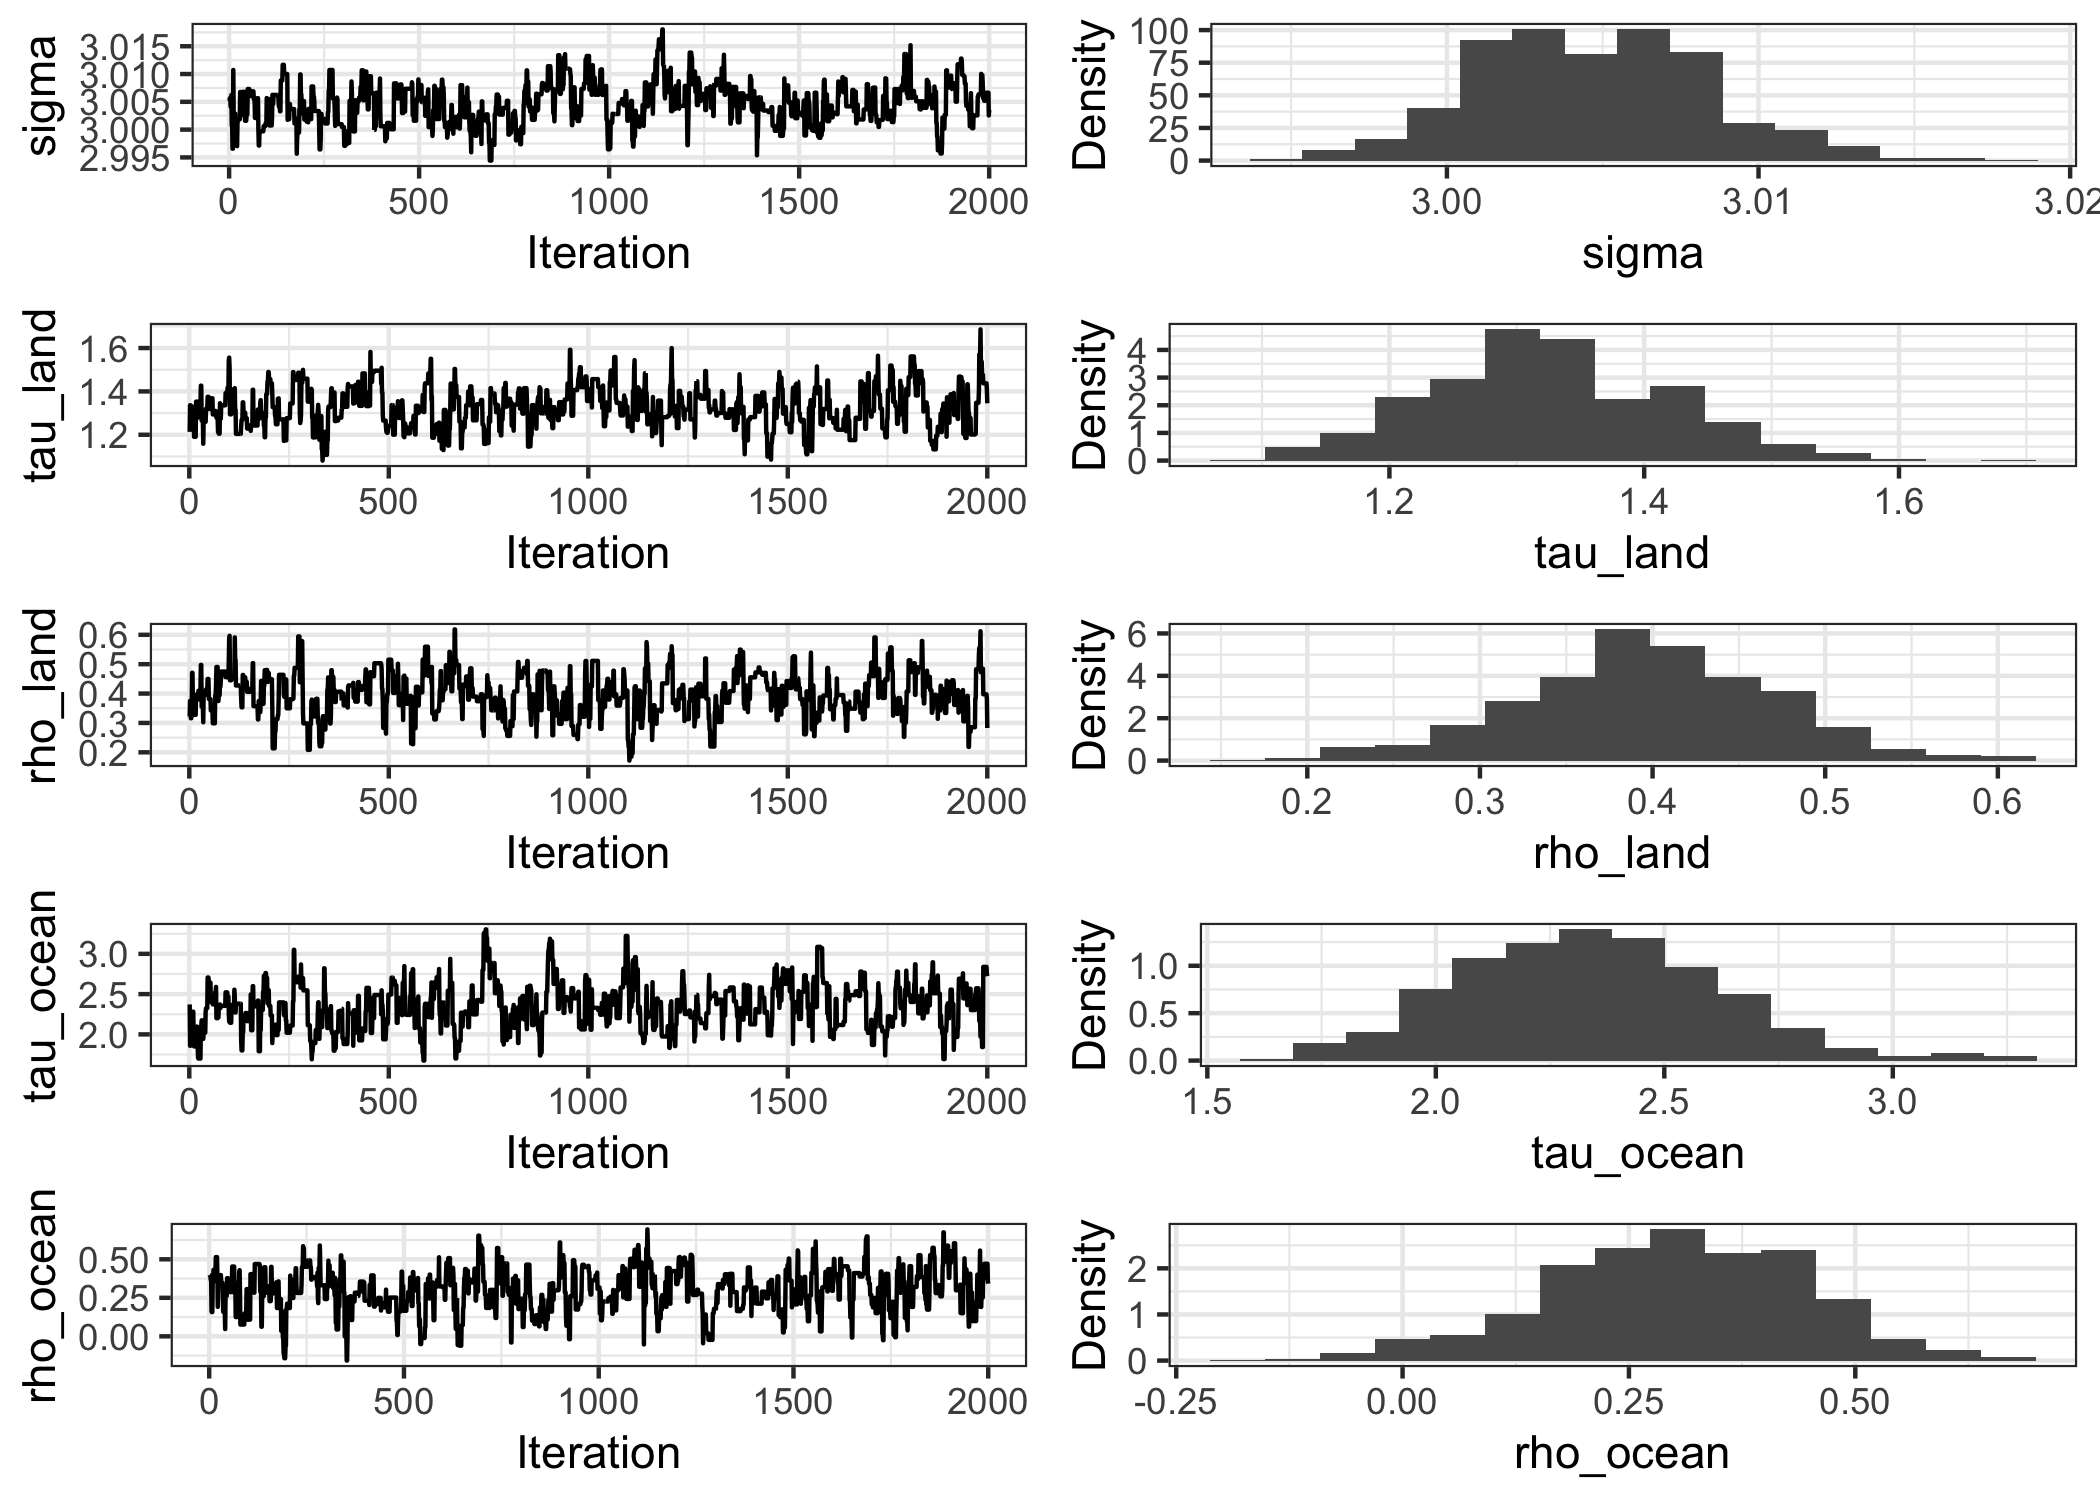

In [17]:
theta_traceplots <- lapply(1 : 5, function(i) {
  theta_i <- theta_samples[, i]
  ggplot(data.frame(
    iteration = seq_along(theta_i),
    x = theta_i
  ), aes(iteration, x)) +
    geom_line() +
    labs(x = 'Iteration', y = theta_names[i])
})

theta_histograms <- lapply(1 : 5, function(i) {
  theta_i <- theta_samples[, i]
  ggplot(data.frame(x = theta_i), aes(x)) +
    geom_histogram(
      mapping = aes(y = after_stat(density)),
      bins = 15
    ) +
    labs(x = theta_names[i], y = 'Density')
})

options(repr.plot.width = 7, repr.plot.height = 5, repr.plot.res = 300)
gridExtra::grid.arrange(
    grobs = list(
        theta_traceplots[[1]], theta_histograms[[1]],
        theta_traceplots[[2]], theta_histograms[[2]],
        theta_traceplots[[3]], theta_histograms[[3]],
        theta_traceplots[[4]], theta_histograms[[4]],
        theta_traceplots[[5]], theta_histograms[[5]]
    ),
    nrow = 5
)

We can look again at the land/ocean fluxes. We now exclude the prior uncertainty since it's so wide:

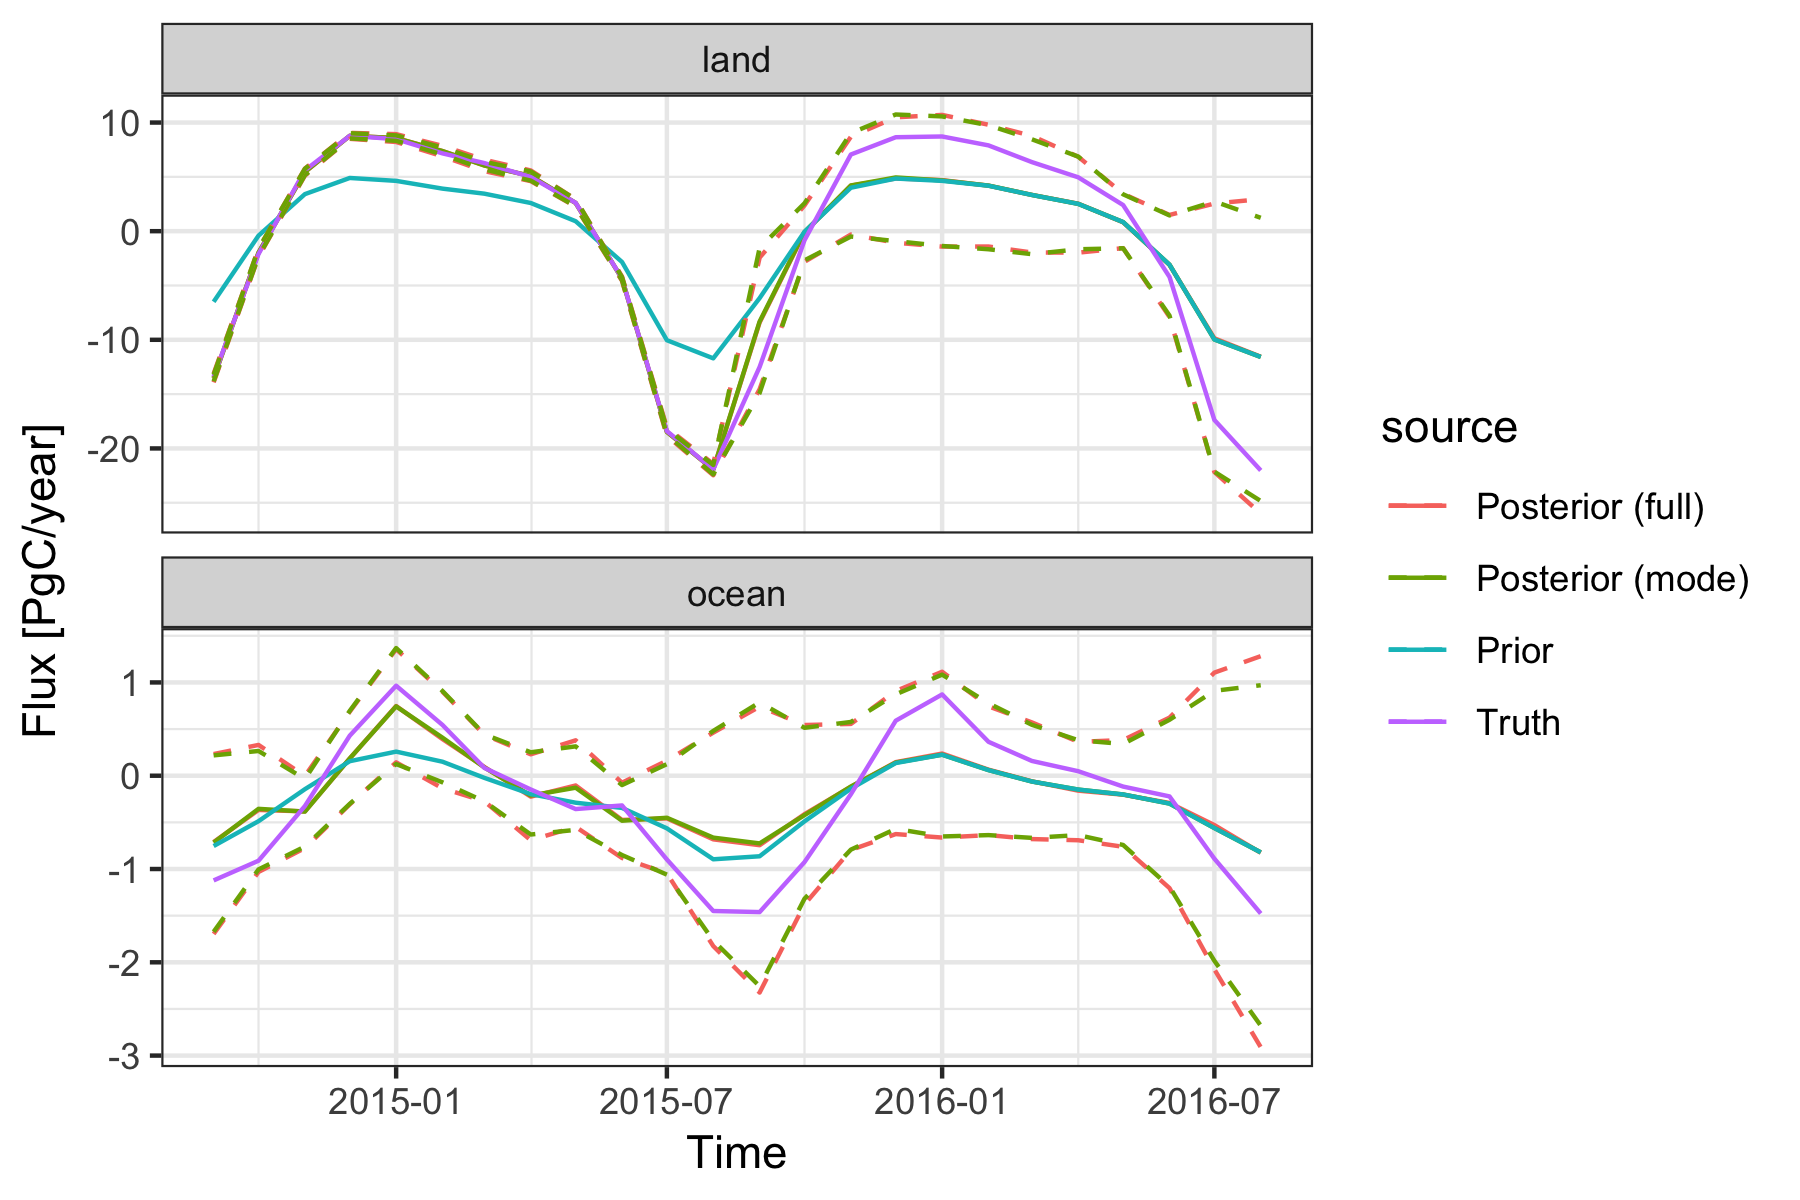

In [18]:
land_ocean_flux_posterior <- x_to_land_ocean_flux(colMeans(x_samples), x_samples)

options(repr.plot.width = 6, repr.plot.height = 4, repr.plot.res = 300)
bind_rows(
    land_ocean_flux_true %>%
        mutate(source = 'Truth'),
    land_ocean_flux_prior %>%
        mutate(source = 'Prior', flux_q025 = NA, flux_q975 = NA),
    land_ocean_flux_mode %>%
        mutate(source = 'Posterior (mode)'),  
    land_ocean_flux_posterior %>%
        mutate(source = 'Posterior (full)')    
) %>%
    ggplot(aes(time, colour = source)) +
        geom_line(mapping = aes(y = flux)) +
        geom_line(mapping = aes(y = flux_q025), linetype = 'dashed', na.rm = TRUE) +
        geom_line(mapping = aes(y = flux_q975), linetype = 'dashed', na.rm = TRUE) +
        facet_wrap(~ region_type, ncol = 1, scales = 'free_y') +
        labs(x = 'Time', y = 'Flux [PgC/year]')

Here it seems there's not such a big difference between the posterior based on the posterior mode of ${\boldsymbol \theta}$ and the full posterior. We can instead look at regional fluxes to see if it makes more of a difference. Below we look at two ocean regions that are very poorly constrained:

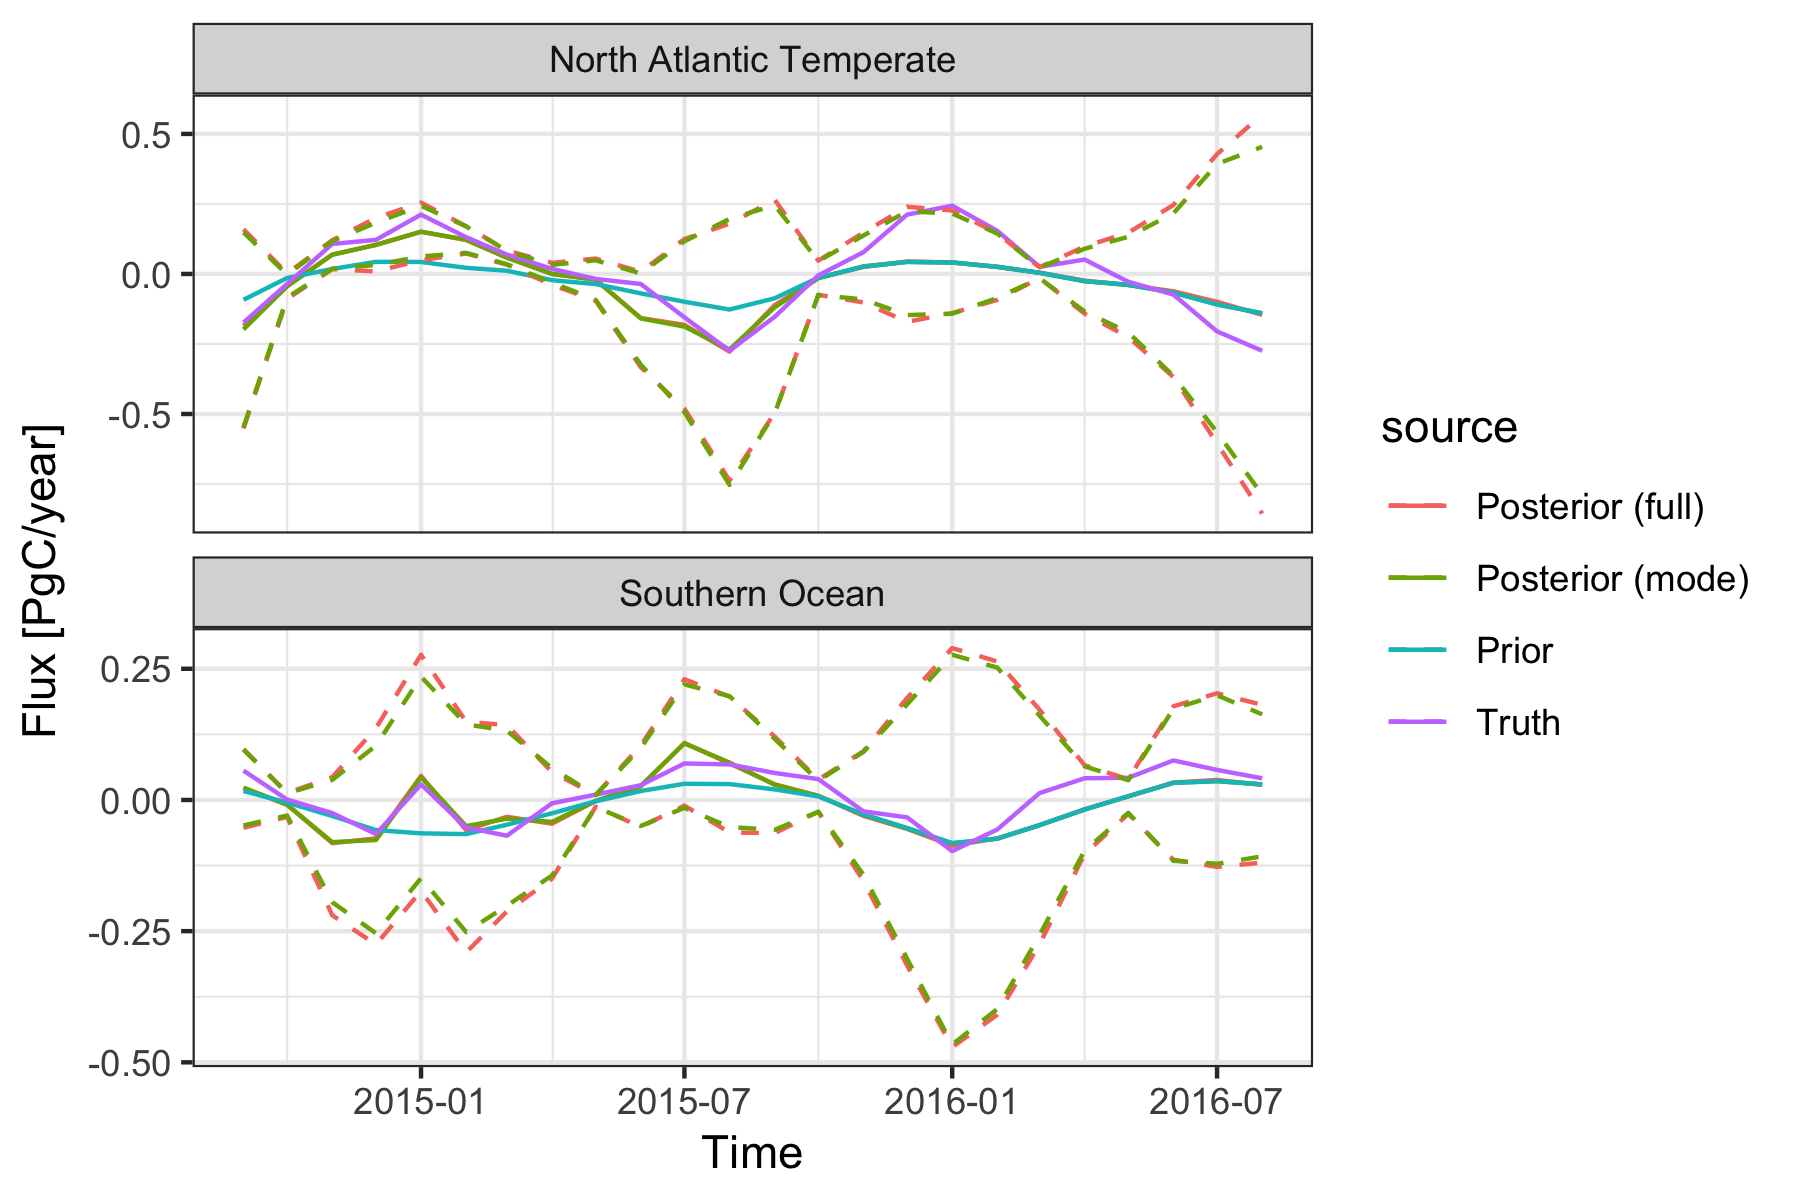

In [19]:
regional_flux_true <- x_to_regional_flux(x_true)
regional_flux_prior <- x_to_regional_flux(rep(0, ncol(H)))
regional_flux_mode <- x_to_regional_flux(x_hat_mode, x_samples_mode)
regional_flux_posterior <- x_to_regional_flux(colMeans(x_samples), x_samples)

options(repr.plot.width = 6, repr.plot.height = 4, repr.plot.res = 300)
bind_rows(
    regional_flux_true %>%
        mutate(source = 'Truth'),
    regional_flux_prior %>%
        mutate(source = 'Prior'),
    regional_flux_mode %>%
        mutate(source = 'Posterior (mode)'),  
    regional_flux_posterior %>%
        mutate(source = 'Posterior (full)')    
) %>%
    filter(
        region_index %in% c(17, 20)
    ) %>%
    ggplot(aes(time, colour = source)) +
        geom_line(mapping = aes(y = flux)) +
        geom_line(mapping = aes(y = flux_q025), linetype = 'dashed', na.rm = TRUE) +
        geom_line(mapping = aes(y = flux_q975), linetype = 'dashed', na.rm = TRUE) +
        facet_wrap(~ region_name, ncol = 1, scales = 'free_y') +
        labs(x = 'Time', y = 'Flux [PgC/year]')

In these regions, the full posterior uncertainty is somewhat wider than the uncertainty from the mode.